# Monte Carlo Pricing

**线性同余发生器（Linear Congruential Generator，LCG）**

线性同余发生器（Linear Congruential Generator，LCG）是一种简单的伪随机数生成算法1。它由以下参数组成：模数（m）、乘数（a）、加数（c）和随机数（X）。LCG算法是一个递推公式，每下一个随机数是当前随机数向左移动log2 a位，加上一个c，最后对m取余，使随机数限制在0~m-1内1。该算法由于构成简单，具有以下优点：计算速度快、易于实现、易于写入硬件。

LCG算法的随机性质受到了广泛的研究和讨论。虽然LCG算法可以产生伪随机数，但是它的随机性质并不理想。在实际应用中，通常需要对LCG算法进行改进或者使用其他更为复杂的随机数生成算法。


使用LCG生成正态分布的随机变量

可以使用Box-Muller变换。Box-Muller变换是一种简单而有效的生成正态分布的方法

是一种通过服从均匀分布的随机变量，来构建服从高斯分布的随机变量的一种方法。它的基本思想是将二维正态分布的随机变量表示为极坐标形式，然后利用均匀分布和指数分布的关系，生成半径和角度的随机变量，最后转换为笛卡尔坐标形式。Box-Muller变换有两种形式：基本形式和极坐标形式。
基本形式是直接利用逆变换法生成指数分布和均匀分布的随机变量。
极坐标形式是利用拒绝采样法生成单位圆内的随机点，然后再转换为指数分布和均匀分布的随机变量。


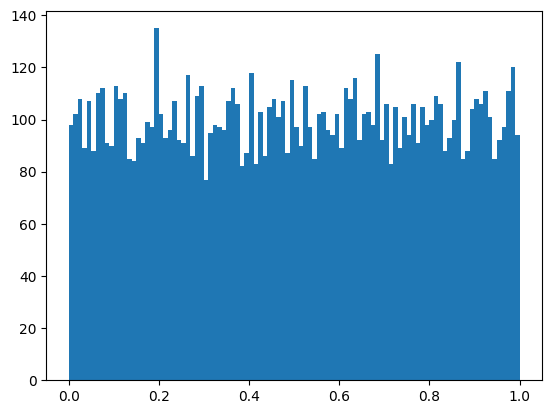

In [40]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import random
def linear_congruential_generator(N, seed = 1):
    """Generates uniform random samples on [0,1]."""
    
    ## Parameters for the Linear Congruential Generator.
    a = 39373
    c = 0
    k = 2**31 - 1

    samples = np.zeros(N)
    xi = seed

    for i in range(N):
        xi = (a * xi + c) % k
        ui = xi / k
        samples[i] = ui

    return samples, xi

# Test Script:
N = 10000
random_U,seed = linear_congruential_generator(N)
np.mean(random_U)
fig = plt.hist(random_U, bins=100)

In [42]:
def marsaglia_bray(seed=1):
    X = 2  # set an initial value so that the while loop is entered
    i = 0
    while X > 1:
        U, seed = linear_congruential_generator(2, seed)
        u1, u2 = U[0],U[1]
        u1 = 2 * u1 - 1
        u2 = 2 * u2 - 1
        X = u1**2 + u2**2
        
    Y = math.sqrt(-2 * math.log(X) / X)
    Z1 = u1 * Y
    Z2 = u2 * Y
    
    return Z1, Z2, seed

## Test Script:
print(marsaglia_bray(2))

(-0.12717924614987783, 0.8922086815064756, 1941397141)


In [43]:
def marsaglia_bray_N(N):
    ## Generate an empty array for the generated values.
    results = np.empty(N, dtype=float)
    index = 0
    seed = 1
    while index < N:
        Z1, Z2, seed = marsaglia_bray(seed)
        
        ## Add the generated values to the results array.
        results[index] = Z1
        index += 1
        
        ## If there's still space, add the second generated value.
        if index < N:
            results[index] = Z2
            index += 1

    return results

## Test Script:
# N = 100_000
# plt.hist(marsaglia_bray_N(N), bins=20)

-0.00626546122503029

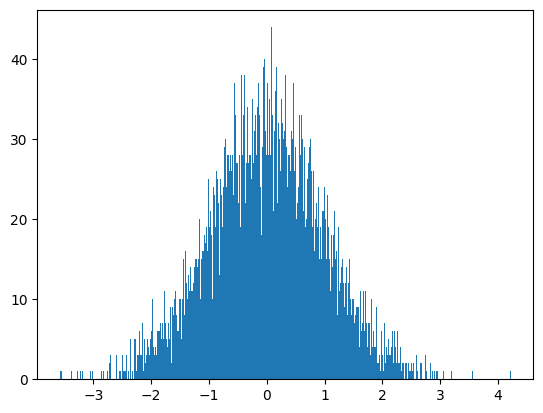

In [46]:
# Test Script:
N = 10000
random_N = marsaglia_bray_N(N)
fig = plt.hist(random_N, bins=1000)
np.mean(random_N)

## Variance Reduction Techniques for Monte Carlo Pricing of European Options

In [6]:
def simulated_spot(S0, T, r, q, sigma, zi):
    """Calculate the simulated spot price S_i at time T."""
    return S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * zi)

def put_payoff(Si, K, T, r):
    """Calculate the discounted payoff of a European put option at time T."""
    return np.exp(-r * T) * np.maximum(K - Si, 0)

In [7]:
def d1(S, K, T, r, q, sigma):
    """Calculates d1 (BSM)."""
    return (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))

def d2(S, K, T, r, q, sigma, d1_val=None):
    """Calculates d2 (BSM)."""
    if d1_val is None:
        d1_val = d1(S, K, T, r, q, sigma)
    return d1_val - sigma * math.sqrt(T)

def bs_call(S, K, T, r, q, sigma):
    """Calculate the value for a European call option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return S * math.exp(-q * T) * norm.cdf(d1_val) - K * math.exp(-r * T) * norm.cdf(d2_val)

def bs_put(S, K, T, r, q, sigma):
    """Calculate the value for a European put option (BSM)."""
    d1_val = d1(S, K, T, r, q, sigma)
    d2_val = d2(S, K, T, r, q, sigma, d1_val)
    return K * math.exp(-r * T) * norm.cdf(- d2_val) - S * math.exp(-q * T) * norm.cdf(- d1_val)

### 1. Control Variate Technique

In [8]:
def HW2_NUM1_CV(S0, K, T, r, q, sigma, z):
    ## Vectorized calculation for all simulated spot prices.
    Si_array = simulated_spot(S0, T, r, q, sigma, z)
    plt.hist(Si_array, bins=10)
    
    ## Vectorized calculation for put payoff.
    Vi_array = put_payoff(Si_array, K, T, r)
    ##plt.hist(Vi_array, bins=10)

    ## Aggregation.
    S_hat = np.mean(Si_array)
    V_hat = np.mean(Vi_array)

    ## Control Variate Technique.
    b_hat = np.sum((Si_array - S_hat) * (Vi_array - V_hat)) / np.sum((Si_array - S_hat)**2)
    Wi_array = Vi_array - b_hat * (Si_array - np.exp(r * T) * S0)
    V_cv_hat = np.mean(Wi_array)

    ## Output results:
    N = len(z)
    print("Results for N =", N)
    print("V_CV_hat(N):", V_cv_hat)
    print("V_BS:", bs_put(S0, K, T, r, q, sigma))
    print("|V_BS - V_CV_hat(N)|:", abs(bs_put(S0, K, T, r, q, sigma) - V_cv_hat))
    print("\n")
    return N, V_cv_hat, abs(bs_put(S0, K, T, r, q, sigma) - V_cv_hat)

Results for N = 10000
V_CV_hat(N): 3.762976882118533
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.038095001708303045


Results for N = 20000
V_CV_hat(N): 3.760174727915477
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.04089715591135912


Results for N = 40000
V_CV_hat(N): 3.798584417438943
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.0024874663878931003


Results for N = 80000
V_CV_hat(N): 3.805737820114191
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.004665936287354899


Results for N = 160000
V_CV_hat(N): 3.811181961648319
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.010110077821483099


Results for N = 320000
V_CV_hat(N): 3.805990838805181
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.004918954978344825


Results for N = 640000
V_CV_hat(N): 3.804925924377765
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.003854040550928861


Results for N = 1280000
V_CV_hat(N): 3.8029039866601155
V_BS: 3.801071883826836
|V_BS - V_CV_hat(N)|: 0.001832102833279503


Results for N = 25

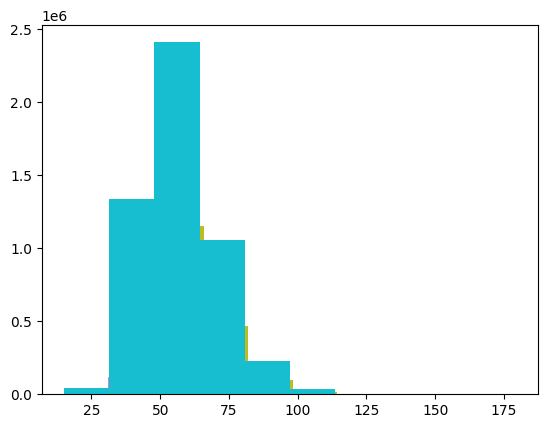

In [47]:
## Table values for control variate technique.

## Given values.
S0 = 56
K = 54
sigma = 0.27
q = 0
r = 0.02
T = 0.75
N = 10000 * (2**9)

z = marsaglia_bray_N(N)
lst = []
for k in range(10):
    end_index = 10000 * (2**k)
    lst.append(HW2_NUM1_CV(S0, K, T, r, q, sigma, z[:end_index]))


In [60]:
import pandas as pd

# put 6 decimals everywhere
output = pd.DataFrame(lst)
output.round(6)
output.to_csv('./q1_1.csv')
output

,0,1,2
0,10000,3.762977,3.809500e-02
1,20000,3.760175,4.089716e-02
2,40000,3.798584,2.487466e-03
3,80000,3.805738,4.665936e-03
4,160000,3.811182,1.011008e-02
5,320000,3.805991,4.918955e-03
6,640000,3.804926,3.854041e-03
7,1280000,3.802904,1.832103e-03
8,2560000,3.801072,1.038221e-09
9,5120000,3.800667,4.047766e-04


### 2. Antithetic Variables

In [63]:
def HW2_NUM1_AV(S0, K, T, r, q, sigma, z):
    ## Vectorized calculation for all simulated spot prices.
    Si1_array = simulated_spot(S0, T, r, q, sigma, z)
    Si2_array = simulated_spot(S0, T, r, q, sigma, -z)
    
    ## Antithetic Variables Technique.
    Vi1_array = put_payoff(Si1_array, K, T, r)
    Vi2_array = put_payoff(Si2_array, K, T, r)
    V_av_hat = (np.mean(Vi1_array) + np.mean(Vi2_array)) / 2

    ## Output results:
    N = len(z)
    return N, V_av_hat,abs(bs_put(S0, K, T, r, q, sigma) - V_av_hat)

ls = []
for k in range(10):
    end_index = 10000 * (2**k)
    ls.append(HW2_NUM1_AV(S0, K, T, r, q, sigma, z[:end_index]))
ls

[(10000, 3.765569398350365, 0.03550248547647117),
 (20000, 3.765214430303043, 0.035857453523793215),
 (40000, 3.7970454621203027, 0.004026421706533334),
 (80000, 3.8034121552159017, 0.0023402713890656734),
 (160000, 3.80809285928284, 0.007020975456003775),
 (320000, 3.8051454410796612, 0.004073557252825211),
 (640000, 3.804768946913102, 0.0036970630862658282),
 (1280000, 3.802765668873329, 0.0016937850464930904),
 (2560000, 3.800853973646405, 0.00021791018043115784),
 (5120000, 3.800499608915894, 0.0005722749109420278)]

In [64]:
# put 6 decimals everywhere
output = pd.DataFrame(ls)
output.round(6)
output.to_csv('./q1_1.csv')
output

,0,1,2
0,10000,3.765569,0.035502
1,20000,3.765214,0.035857
2,40000,3.797045,0.004026
3,80000,3.803412,0.002340
4,160000,3.808093,0.007021
5,320000,3.805145,0.004074
6,640000,3.804769,0.003697
7,1280000,3.802766,0.001694
8,2560000,3.800854,0.000218
9,5120000,3.800500,0.000572


### 3. Moment Matching

In [61]:
def HW2_NUM1_MM(S0, K, T, r, q, sigma, z):
    ## Vectorized calculation for all simulated spot prices.
    Si_array = simulated_spot(S0, T, r, q, sigma, z)

    ## Aggregation.
    S_hat = np.mean(Si_array)

    ## Moment matching technique.
    Si_tilda_array = (np.exp(r*T)*S0/S_hat) * Si_array
    Vi_tilda_array = put_payoff(Si_tilda_array, K, T, r)
    V_mm_hat = np.mean(Vi_tilda_array)

    ## Output results:
    N = len(z)

    return N, V_mm_hat,abs(bs_put(S0, K, T, r, q, sigma) - V_mm_hat)
## Table values for moment matching technique.
ls = []
for k in range(10):
    end_index = 10000 * (2**k)
    ls.append(HW2_NUM1_MM(S0, K, T, r, q, sigma, z[:end_index]))


[(10000, 3.758879248746038, 0.04219263508079818),
 (20000, 3.7584481485562944, 0.04262373527054164),
 (40000, 3.797759051858886, 0.0033128319679498475),
 (80000, 3.805040627815494, 0.0039687439886577636),
 (160000, 3.8100138105616193, 0.008941926734783223),
 (320000, 3.806129769131595, 0.0050578853047591465),
 (640000, 3.8053177682133223, 0.0042458843864863205),
 (1280000, 3.8030411835162137, 0.001969299689377646),
 (2560000, 3.8009817806465915, 9.010318024449404e-05),
 (5120000, 3.800750041218082, 0.00032184260875389725)]

In [62]:
# put 6 decimals everywhere
output = pd.DataFrame(ls)
output.round(6)
output.to_csv('./q1_1.csv')
output

,0,1,2
0,10000,3.758879,0.042193
1,20000,3.758448,0.042624
2,40000,3.797759,0.003313
3,80000,3.805041,0.003969
4,160000,3.810014,0.008942
5,320000,3.806130,0.005058
6,640000,3.805318,0.004246
7,1280000,3.803041,0.001969
8,2560000,3.800982,0.000090
9,5120000,3.800750,0.000322


### 4. Simultaneous Moment Matching and Control Variates

In [65]:
def HW2_NUM1_CVMM(S0, K, T, r, q, sigma, z):
    ## Vectorized calculation for all simulated spot prices.
    Si_array = simulated_spot(S0, T, r, q, sigma, z)

    ## Aggregation.
    S_hat = np.mean(Si_array)

    ## Moment matching technique.
    Si_tilda_array = (np.exp(r*T)*S0/S_hat) * Si_array
    Vi_tilda_array = put_payoff(Si_tilda_array, K, T, r)
    V_mm_hat = np.mean(Vi_tilda_array)

    ## Control Variate Technique.
    b_hat = np.sum((Si_tilda_array - np.exp(r*T)*S0) * (Vi_tilda_array - V_mm_hat)) / np.sum((Si_tilda_array - np.exp(r*T)*S0)**2)
    Wi_array = Vi_tilda_array - b_hat * (Si_tilda_array - np.exp(r * T) * S0)
    V_cvmm_hat = np.mean(Wi_array)
    
    ## Output results:
    N = len(z)
    return N, V_cvmm_hat ,abs(bs_put(S0, K, T, r, q, sigma) - V_cvmm_hat)

ls = []
for k in range(10):
    end_index = 10000 * (2**k)
    ls.append(HW2_NUM1_CVMM(S0, K, T, r, q, sigma, z[:end_index]))
ls


[(10000, 3.7588792487460343, 0.04219263508080173),
 (20000, 3.758448148556293, 0.04262373527054297),
 (40000, 3.7977590518588884, 0.003312831967947627),
 (80000, 3.805040627815492, 0.003968743988655987),
 (160000, 3.810013810561622, 0.008941926734785888),
 (320000, 3.806129769131602, 0.005057885304765808),
 (640000, 3.8053177682133246, 0.004245884386488541),
 (1280000, 3.8030411835162194, 0.001969299689383419),
 (2560000, 3.8009817806465938, 9.01031802422736e-05),
 (5120000, 3.800750041218097, 0.0003218426087392423)]

In [66]:
# put 6 decimals everywhere
output = pd.DataFrame(ls)
output.round(6)
output.to_csv('./q1_1.csv')
output

,0,1,2
0,10000,3.758879,0.042193
1,20000,3.758448,0.042624
2,40000,3.797759,0.003313
3,80000,3.805041,0.003969
4,160000,3.810014,0.008942
5,320000,3.806130,0.005058
6,640000,3.805318,0.004246
7,1280000,3.803041,0.001969
8,2560000,3.800982,0.000090
9,5120000,3.800750,0.000322


## Monte Carlo Pricing for Basket Options


We want to price European basket options on two underlying assets following a lognormal model with known correlation using Monte Carlo simulation.

Since the payoff of the option depends only on the price of the underlying assets at maturity, we do not need to generate entire paths for the evolution of the underlying assets, just their prices at maturity

max(S1(T) + S2(T) − K, 0).

Generate 2N independent samples z1, z2, . . . , z2N from the standard normal distribution using the linear congruential generator and the Box–Muller Method.

![Alt text](image-3.png)